# <center>House Prices - Advanced Regression Techniques<center>

<p style='text-align: justify;'> O objetivo deste trabalho é apresentar uma solução simples para a competição House Prices - Advanced Regression Techniques
presente no Kaggle. Com poucas linhas de código, usando apenas um modelo (CatBoostRegressor) e com quase nenhum trabalho de Feature Engineering conseguimos obter um bom score (top 15%) .

Mais informações sobre a competição em: https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview

In [1]:
# Algumas importações básicas

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from catboost import CatBoostRegressor
from IPython.display import Image

In [2]:
# Lendo os arquivos de treino e teste

train = pd.read_csv('train_house.csv')
test = pd.read_csv('test_house.csv')

In [3]:
# Dimensão do dataset de treino

train.shape

(1460, 81)

In [4]:
# Dimensão do dataset de teste

test.shape

(1459, 80)

In [5]:
# Observando as 5 primeiras linhas do dataset de treino

train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Tratamento de Valores Ausentes

In [6]:
# Antes de tudo vamos concatenar os datasets de treino e de teste

train_test = pd.concat([train , test] , axis = 0)

In [7]:
# Features e número de valores ausentes por Feature

train_test.isnull().sum()

Id                  0
MSSubClass          0
MSZoning            4
LotFrontage       486
LotArea             0
                 ... 
MoSold              0
YrSold              0
SaleType            1
SaleCondition       0
SalePrice        1459
Length: 81, dtype: int64

In [8]:
# Mostrando apenas as Features que possuem valores ausentes e a quantidade de valores ausentes

for index , count in zip(list(train_test.isnull().sum().index) , list(train_test.isnull().sum())) :
    if count > 0 :
        print(index , ":", count )

MSZoning : 4
LotFrontage : 486
Alley : 2721
Utilities : 2
Exterior1st : 1
Exterior2nd : 1
MasVnrType : 24
MasVnrArea : 23
BsmtQual : 81
BsmtCond : 82
BsmtExposure : 82
BsmtFinType1 : 79
BsmtFinSF1 : 1
BsmtFinType2 : 80
BsmtFinSF2 : 1
BsmtUnfSF : 1
TotalBsmtSF : 1
Electrical : 1
BsmtFullBath : 2
BsmtHalfBath : 2
KitchenQual : 1
Functional : 2
FireplaceQu : 1420
GarageType : 157
GarageYrBlt : 159
GarageFinish : 159
GarageCars : 1
GarageArea : 1
GarageQual : 159
GarageCond : 159
PoolQC : 2909
Fence : 2348
MiscFeature : 2814
SaleType : 1
SalePrice : 1459


In [9]:
# Observando os tipos de dados existentes no dataframe train_test

np.unique(train_test.dtypes)

array([dtype('int64'), dtype('float64'), dtype('O')], dtype=object)

Vamos adotar a seguinte estratégia para colunas que possuem menos de 500 valores ausentes : Para dados numéricos (int64 e float64) vamos substituir os valores ausentes pela média da coluna e para dados categóricos vamos substituir os valores ausentes pelo valor mais comum.

In [10]:
features = list(train_test.columns)
features.remove('SalePrice')
for feature in features :
    if train_test[feature].isnull().sum() < 500 :
        if train[feature].dtype == 'int64' or train[feature].dtype == 'float64' :
            train_test.loc[train_test[feature].isnull() , feature] = train[feature].mean()
        else :
            train_test.loc[train_test[feature].isnull() , feature] = train[feature].value_counts().index[0]

In [11]:
# Observando as colunas que ainda possuem valores nulos

for feature, count_null in zip(train_test.isnull().sum().index , train_test.isnull().sum()) :
    print (feature , ":" , count_null)

Id : 0
MSSubClass : 0
MSZoning : 0
LotFrontage : 0
LotArea : 0
Street : 0
Alley : 2721
LotShape : 0
LandContour : 0
Utilities : 0
LotConfig : 0
LandSlope : 0
Neighborhood : 0
Condition1 : 0
Condition2 : 0
BldgType : 0
HouseStyle : 0
OverallQual : 0
OverallCond : 0
YearBuilt : 0
YearRemodAdd : 0
RoofStyle : 0
RoofMatl : 0
Exterior1st : 0
Exterior2nd : 0
MasVnrType : 0
MasVnrArea : 0
ExterQual : 0
ExterCond : 0
Foundation : 0
BsmtQual : 0
BsmtCond : 0
BsmtExposure : 0
BsmtFinType1 : 0
BsmtFinSF1 : 0
BsmtFinType2 : 0
BsmtFinSF2 : 0
BsmtUnfSF : 0
TotalBsmtSF : 0
Heating : 0
HeatingQC : 0
CentralAir : 0
Electrical : 0
1stFlrSF : 0
2ndFlrSF : 0
LowQualFinSF : 0
GrLivArea : 0
BsmtFullBath : 0
BsmtHalfBath : 0
FullBath : 0
HalfBath : 0
BedroomAbvGr : 0
KitchenAbvGr : 0
KitchenQual : 0
TotRmsAbvGrd : 0
Functional : 0
Fireplaces : 0
FireplaceQu : 1420
GarageType : 0
GarageYrBlt : 0
GarageFinish : 0
GarageCars : 0
GarageArea : 0
GarageQual : 0
GarageCond : 0
PavedDrive : 0
WoodDeckSF : 0
OpenPorc

In [12]:
# Vamos excluir as features que possuem mais de 500 valores nulos

train_test.drop(['Alley' , 'FireplaceQu' , 'PoolQC' , 'Fence' , 'MiscFeature'] , axis = 1 , inplace = True)

##  Feature Engineering

In [13]:
np.unique(train_test.dtypes)

array([dtype('float64'), dtype('O')], dtype=object)

In [14]:
# Selecionando apenas as features numéricas

features_num = []

for feature in train_test.columns :
    if train_test[feature].dtype == 'float64' :
        features_num.append(feature)

In [15]:
# Removendo algumas features numéricas que não serão importantes para o treinamento do modelo

features_num.remove('Id')
features_num.remove('SalePrice')

In [16]:
# Criando novas colunas no dataframe train_test a partir das features categóricas com a função pd.get_dummies

for feature in train_test.columns :
    if train_test[feature].dtype != 'float64' :
        train_test = pd.concat([train_test , pd.get_dummies(train_test[feature] , prefix = feature)] , axis = 1)

In [17]:
# Novas Features

train_test.columns[76:]

Index(['MSZoning_C (all)', 'MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL',
       'MSZoning_RM', 'Street_Grvl', 'Street_Pave', 'LotShape_IR1',
       'LotShape_IR2', 'LotShape_IR3',
       ...
       'SaleType_ConLw', 'SaleType_New', 'SaleType_Oth', 'SaleType_WD',
       'SaleCondition_Abnorml', 'SaleCondition_AdjLand',
       'SaleCondition_Alloca', 'SaleCondition_Family', 'SaleCondition_Normal',
       'SaleCondition_Partial'],
      dtype='object', length=234)

In [18]:
# Selecionando todas as Features que utilizaremos

features = features_num + list(train_test.columns[76:])

In [19]:
# Desconcatenando o dataframe train_test

train_test.index = list(range(1 , 2920, 1))

train = train_test.loc[list(range(1, 1461, 1)) , :]

test = train_test.loc[list(range(1461 , 2920 , 1)) , :]

## Validação Cruzada

In [20]:
# Criando a métrica utilizada na competição

def score(estimator, X, y):
    pred = estimator.predict(X)
    res = np.sqrt((sum((np.log(pred) - np.log(y))**2))/len(list(y)))
    return res

Após analisar alguns modelos o CatBoostRegressor parece funcionar melhor. Vamos ver o seu score de validação cruzada.

In [21]:
np.mean(cross_val_score(CatBoostRegressor() , train[features] , train['SalePrice'] , cv = 5 , scoring = score))

Learning rate set to 0.04196
0:	learn: 78349.6741112	total: 190ms	remaining: 3m 9s
1:	learn: 76307.2724640	total: 238ms	remaining: 1m 58s
2:	learn: 74335.5652439	total: 300ms	remaining: 1m 39s
3:	learn: 72458.0709961	total: 344ms	remaining: 1m 25s
4:	learn: 70768.1175013	total: 385ms	remaining: 1m 16s
5:	learn: 69184.4113327	total: 431ms	remaining: 1m 11s
6:	learn: 67535.7745987	total: 502ms	remaining: 1m 11s
7:	learn: 66010.0186340	total: 593ms	remaining: 1m 13s
8:	learn: 64415.6154799	total: 668ms	remaining: 1m 13s
9:	learn: 62848.3251041	total: 732ms	remaining: 1m 12s
10:	learn: 61334.9617482	total: 827ms	remaining: 1m 14s
11:	learn: 59875.1319716	total: 922ms	remaining: 1m 15s
12:	learn: 58644.7096980	total: 1.02s	remaining: 1m 17s
13:	learn: 57428.9921176	total: 1.15s	remaining: 1m 21s
14:	learn: 56250.4643075	total: 1.25s	remaining: 1m 22s
15:	learn: 54963.8811389	total: 1.37s	remaining: 1m 24s
16:	learn: 53788.8332740	total: 1.46s	remaining: 1m 24s
17:	learn: 52743.5783433	total

149:	learn: 18802.9288852	total: 7.7s	remaining: 43.6s
150:	learn: 18766.2135027	total: 7.74s	remaining: 43.5s
151:	learn: 18699.3311326	total: 7.77s	remaining: 43.4s
152:	learn: 18654.7545921	total: 7.81s	remaining: 43.2s
153:	learn: 18588.2886890	total: 7.85s	remaining: 43.1s
154:	learn: 18536.1390598	total: 7.88s	remaining: 43s
155:	learn: 18501.8301430	total: 7.91s	remaining: 42.8s
156:	learn: 18463.1885360	total: 7.97s	remaining: 42.8s
157:	learn: 18419.1570595	total: 8.01s	remaining: 42.7s
158:	learn: 18363.5358287	total: 8.04s	remaining: 42.6s
159:	learn: 18308.6675924	total: 8.08s	remaining: 42.4s
160:	learn: 18265.8551450	total: 8.12s	remaining: 42.3s
161:	learn: 18222.6677840	total: 8.19s	remaining: 42.4s
162:	learn: 18175.4834993	total: 8.23s	remaining: 42.3s
163:	learn: 18111.7475999	total: 8.27s	remaining: 42.2s
164:	learn: 18075.2219079	total: 8.31s	remaining: 42.1s
165:	learn: 18015.3384511	total: 8.35s	remaining: 41.9s
166:	learn: 17976.4306409	total: 8.38s	remaining: 4

302:	learn: 14196.6294768	total: 14.7s	remaining: 33.8s
303:	learn: 14168.0574213	total: 14.7s	remaining: 33.7s
304:	learn: 14133.7766601	total: 14.8s	remaining: 33.6s
305:	learn: 14114.9359315	total: 14.8s	remaining: 33.6s
306:	learn: 14090.1844510	total: 14.8s	remaining: 33.5s
307:	learn: 14052.4895446	total: 14.9s	remaining: 33.4s
308:	learn: 14027.8703884	total: 14.9s	remaining: 33.3s
309:	learn: 14015.8776686	total: 15s	remaining: 33.3s
310:	learn: 13993.3431211	total: 15s	remaining: 33.2s
311:	learn: 13957.9369874	total: 15s	remaining: 33.2s
312:	learn: 13939.5528483	total: 15.1s	remaining: 33.1s
313:	learn: 13922.7578841	total: 15.1s	remaining: 33s
314:	learn: 13915.0976601	total: 15.1s	remaining: 32.9s
315:	learn: 13879.5778708	total: 15.2s	remaining: 32.9s
316:	learn: 13854.6682342	total: 15.2s	remaining: 32.8s
317:	learn: 13816.9040487	total: 15.3s	remaining: 32.8s
318:	learn: 13792.9555209	total: 15.3s	remaining: 32.7s
319:	learn: 13778.2653704	total: 15.4s	remaining: 32.6s


451:	learn: 11427.6820505	total: 20.9s	remaining: 25.3s
452:	learn: 11412.4863568	total: 20.9s	remaining: 25.2s
453:	learn: 11410.6281246	total: 20.9s	remaining: 25.2s
454:	learn: 11396.9787589	total: 21s	remaining: 25.1s
455:	learn: 11371.2600663	total: 21s	remaining: 25.1s
456:	learn: 11361.8729244	total: 21.1s	remaining: 25s
457:	learn: 11343.0291953	total: 21.1s	remaining: 25s
458:	learn: 11316.5590952	total: 21.1s	remaining: 24.9s
459:	learn: 11294.0056100	total: 21.2s	remaining: 24.9s
460:	learn: 11268.7783820	total: 21.2s	remaining: 24.8s
461:	learn: 11249.6314723	total: 21.3s	remaining: 24.8s
462:	learn: 11233.5544344	total: 21.3s	remaining: 24.7s
463:	learn: 11230.2893023	total: 21.3s	remaining: 24.7s
464:	learn: 11226.5523603	total: 21.4s	remaining: 24.6s
465:	learn: 11199.4157153	total: 21.4s	remaining: 24.5s
466:	learn: 11187.3402646	total: 21.4s	remaining: 24.5s
467:	learn: 11166.9457219	total: 21.5s	remaining: 24.4s
468:	learn: 11152.4472342	total: 21.5s	remaining: 24.4s


602:	learn: 9341.0489867	total: 27.4s	remaining: 18.1s
603:	learn: 9334.9863192	total: 27.5s	remaining: 18s
604:	learn: 9317.2803905	total: 27.6s	remaining: 18s
605:	learn: 9307.2262019	total: 27.6s	remaining: 17.9s
606:	learn: 9286.5828783	total: 27.7s	remaining: 17.9s
607:	learn: 9263.3214974	total: 27.7s	remaining: 17.9s
608:	learn: 9252.6647034	total: 27.7s	remaining: 17.8s
609:	learn: 9244.1106381	total: 27.8s	remaining: 17.8s
610:	learn: 9229.5631878	total: 27.8s	remaining: 17.7s
611:	learn: 9218.2321108	total: 27.8s	remaining: 17.6s
612:	learn: 9212.6373058	total: 27.9s	remaining: 17.6s
613:	learn: 9198.6728516	total: 27.9s	remaining: 17.5s
614:	learn: 9186.7714607	total: 28s	remaining: 17.5s
615:	learn: 9178.9778709	total: 28s	remaining: 17.4s
616:	learn: 9176.0329819	total: 28s	remaining: 17.4s
617:	learn: 9165.8198412	total: 28s	remaining: 17.3s
618:	learn: 9142.6635884	total: 28.1s	remaining: 17.3s
619:	learn: 9126.9207810	total: 28.1s	remaining: 17.2s
620:	learn: 9116.37919

754:	learn: 7739.2054999	total: 33.3s	remaining: 10.8s
755:	learn: 7728.6796533	total: 33.4s	remaining: 10.8s
756:	learn: 7717.5844378	total: 33.4s	remaining: 10.7s
757:	learn: 7711.1829562	total: 33.5s	remaining: 10.7s
758:	learn: 7696.7907638	total: 33.5s	remaining: 10.6s
759:	learn: 7683.7198080	total: 33.6s	remaining: 10.6s
760:	learn: 7672.6587397	total: 33.6s	remaining: 10.6s
761:	learn: 7664.4375380	total: 33.7s	remaining: 10.5s
762:	learn: 7647.2240229	total: 33.7s	remaining: 10.5s
763:	learn: 7634.6630841	total: 33.8s	remaining: 10.4s
764:	learn: 7629.2347187	total: 33.8s	remaining: 10.4s
765:	learn: 7621.3838547	total: 33.9s	remaining: 10.3s
766:	learn: 7620.3313031	total: 33.9s	remaining: 10.3s
767:	learn: 7611.8118894	total: 34s	remaining: 10.3s
768:	learn: 7610.8256701	total: 34s	remaining: 10.2s
769:	learn: 7602.1471570	total: 34.1s	remaining: 10.2s
770:	learn: 7588.1641421	total: 34.1s	remaining: 10.1s
771:	learn: 7587.3908253	total: 34.2s	remaining: 10.1s
772:	learn: 75

908:	learn: 6554.2571959	total: 39.4s	remaining: 3.95s
909:	learn: 6547.3108202	total: 39.5s	remaining: 3.9s
910:	learn: 6542.0523216	total: 39.5s	remaining: 3.86s
911:	learn: 6539.9030110	total: 39.5s	remaining: 3.82s
912:	learn: 6536.5063909	total: 39.6s	remaining: 3.78s
913:	learn: 6531.6153807	total: 39.7s	remaining: 3.73s
914:	learn: 6526.8097253	total: 39.7s	remaining: 3.69s
915:	learn: 6519.7076751	total: 39.8s	remaining: 3.65s
916:	learn: 6509.4636149	total: 39.9s	remaining: 3.61s
917:	learn: 6503.5587372	total: 39.9s	remaining: 3.56s
918:	learn: 6493.7476658	total: 39.9s	remaining: 3.52s
919:	learn: 6492.0960810	total: 39.9s	remaining: 3.47s
920:	learn: 6484.9035041	total: 40s	remaining: 3.43s
921:	learn: 6475.1205724	total: 40s	remaining: 3.38s
922:	learn: 6469.6912649	total: 40s	remaining: 3.34s
923:	learn: 6468.1139357	total: 40.1s	remaining: 3.3s
924:	learn: 6464.2186480	total: 40.1s	remaining: 3.25s
925:	learn: 6454.3785160	total: 40.2s	remaining: 3.21s
926:	learn: 6443.7

62:	learn: 27355.1641631	total: 2.66s	remaining: 39.6s
63:	learn: 27142.8199148	total: 2.7s	remaining: 39.6s
64:	learn: 26897.2004868	total: 2.79s	remaining: 40.1s
65:	learn: 26684.4283055	total: 2.84s	remaining: 40.2s
66:	learn: 26518.5893099	total: 2.89s	remaining: 40.2s
67:	learn: 26297.0964551	total: 2.92s	remaining: 40s
68:	learn: 26121.6885456	total: 2.99s	remaining: 40.4s
69:	learn: 25925.2234268	total: 3.03s	remaining: 40.2s
70:	learn: 25697.2121529	total: 3.06s	remaining: 40s
71:	learn: 25527.3202377	total: 3.09s	remaining: 39.8s
72:	learn: 25361.0480649	total: 3.12s	remaining: 39.6s
73:	learn: 25169.0447353	total: 3.15s	remaining: 39.4s
74:	learn: 25021.5786884	total: 3.18s	remaining: 39.2s
75:	learn: 24851.1152810	total: 3.23s	remaining: 39.3s
76:	learn: 24720.7790756	total: 3.31s	remaining: 39.7s
77:	learn: 24531.0915148	total: 3.35s	remaining: 39.6s
78:	learn: 24359.7372503	total: 3.4s	remaining: 39.6s
79:	learn: 24192.8032268	total: 3.43s	remaining: 39.4s
80:	learn: 24058

213:	learn: 16215.6769960	total: 9.42s	remaining: 34.6s
214:	learn: 16206.0589036	total: 9.51s	remaining: 34.7s
215:	learn: 16163.6126298	total: 9.54s	remaining: 34.6s
216:	learn: 16151.0483259	total: 9.57s	remaining: 34.5s
217:	learn: 16114.7512681	total: 9.61s	remaining: 34.5s
218:	learn: 16104.0390451	total: 9.64s	remaining: 34.4s
219:	learn: 16062.2135057	total: 9.67s	remaining: 34.3s
220:	learn: 16054.6138006	total: 9.71s	remaining: 34.2s
221:	learn: 16046.3812583	total: 9.75s	remaining: 34.2s
222:	learn: 16011.9337120	total: 9.8s	remaining: 34.2s
223:	learn: 16001.7023436	total: 9.82s	remaining: 34s
224:	learn: 15964.4763752	total: 9.85s	remaining: 33.9s
225:	learn: 15956.9840151	total: 9.88s	remaining: 33.9s
226:	learn: 15910.4022730	total: 9.94s	remaining: 33.9s
227:	learn: 15866.9136684	total: 9.98s	remaining: 33.8s
228:	learn: 15830.7422315	total: 10s	remaining: 33.7s
229:	learn: 15794.6875621	total: 10s	remaining: 33.6s
230:	learn: 15755.0892376	total: 10.1s	remaining: 33.5s

361:	learn: 12650.0723374	total: 15.5s	remaining: 27.3s
362:	learn: 12626.0609337	total: 15.5s	remaining: 27.3s
363:	learn: 12613.3732519	total: 15.6s	remaining: 27.2s
364:	learn: 12589.4937090	total: 15.6s	remaining: 27.2s
365:	learn: 12556.3594706	total: 15.6s	remaining: 27.1s
366:	learn: 12524.3751825	total: 15.7s	remaining: 27s
367:	learn: 12503.0058745	total: 15.7s	remaining: 27s
368:	learn: 12493.9370669	total: 15.8s	remaining: 27s
369:	learn: 12465.7320037	total: 15.8s	remaining: 26.9s
370:	learn: 12456.9073864	total: 15.9s	remaining: 26.9s
371:	learn: 12442.0883458	total: 15.9s	remaining: 26.8s
372:	learn: 12436.3655728	total: 15.9s	remaining: 26.8s
373:	learn: 12427.9803217	total: 16s	remaining: 26.7s
374:	learn: 12401.9993164	total: 16s	remaining: 26.7s
375:	learn: 12362.4768906	total: 16s	remaining: 26.6s
376:	learn: 12343.4668083	total: 16.1s	remaining: 26.5s
377:	learn: 12317.4109518	total: 16.1s	remaining: 26.5s
378:	learn: 12304.7855943	total: 16.1s	remaining: 26.4s
379:

510:	learn: 10268.6613579	total: 22.1s	remaining: 21.2s
511:	learn: 10247.8680507	total: 22.1s	remaining: 21.1s
512:	learn: 10227.9021920	total: 22.2s	remaining: 21s
513:	learn: 10214.4376920	total: 22.2s	remaining: 21s
514:	learn: 10202.9968212	total: 22.2s	remaining: 20.9s
515:	learn: 10201.0790296	total: 22.3s	remaining: 20.9s
516:	learn: 10181.9458661	total: 22.3s	remaining: 20.9s
517:	learn: 10164.5851029	total: 22.4s	remaining: 20.8s
518:	learn: 10150.6121275	total: 22.4s	remaining: 20.8s
519:	learn: 10134.0470162	total: 22.4s	remaining: 20.7s
520:	learn: 10113.2043866	total: 22.5s	remaining: 20.7s
521:	learn: 10111.0666542	total: 22.5s	remaining: 20.6s
522:	learn: 10086.7376002	total: 22.5s	remaining: 20.5s
523:	learn: 10071.2938761	total: 22.6s	remaining: 20.5s
524:	learn: 10055.0207083	total: 22.6s	remaining: 20.5s
525:	learn: 10041.6420673	total: 22.6s	remaining: 20.4s
526:	learn: 10018.6126781	total: 22.7s	remaining: 20.4s
527:	learn: 10009.8454083	total: 22.7s	remaining: 20

664:	learn: 8326.9872023	total: 28.5s	remaining: 14.3s
665:	learn: 8317.6106118	total: 28.5s	remaining: 14.3s
666:	learn: 8302.5321351	total: 28.5s	remaining: 14.2s
667:	learn: 8284.3314248	total: 28.6s	remaining: 14.2s
668:	learn: 8282.4291953	total: 28.6s	remaining: 14.2s
669:	learn: 8278.2667544	total: 28.6s	remaining: 14.1s
670:	learn: 8276.0623185	total: 28.7s	remaining: 14.1s
671:	learn: 8259.7903553	total: 28.7s	remaining: 14s
672:	learn: 8254.4122621	total: 28.7s	remaining: 14s
673:	learn: 8243.8979717	total: 28.8s	remaining: 13.9s
674:	learn: 8227.7262998	total: 28.8s	remaining: 13.9s
675:	learn: 8219.0443654	total: 28.9s	remaining: 13.8s
676:	learn: 8204.1622980	total: 28.9s	remaining: 13.8s
677:	learn: 8182.2096011	total: 28.9s	remaining: 13.7s
678:	learn: 8169.0142517	total: 29s	remaining: 13.7s
679:	learn: 8161.3672177	total: 29s	remaining: 13.6s
680:	learn: 8148.4667223	total: 29.1s	remaining: 13.6s
681:	learn: 8135.5008077	total: 29.1s	remaining: 13.6s
682:	learn: 8128.9

818:	learn: 6819.7305402	total: 34.4s	remaining: 7.59s
819:	learn: 6808.3971621	total: 34.4s	remaining: 7.55s
820:	learn: 6789.1035737	total: 34.4s	remaining: 7.51s
821:	learn: 6772.8523735	total: 34.5s	remaining: 7.46s
822:	learn: 6761.0385230	total: 34.5s	remaining: 7.42s
823:	learn: 6752.9430727	total: 34.5s	remaining: 7.37s
824:	learn: 6733.9623349	total: 34.6s	remaining: 7.33s
825:	learn: 6723.5821545	total: 34.6s	remaining: 7.29s
826:	learn: 6717.0410466	total: 34.6s	remaining: 7.24s
827:	learn: 6712.1700280	total: 34.7s	remaining: 7.2s
828:	learn: 6707.4769707	total: 34.7s	remaining: 7.15s
829:	learn: 6703.7259539	total: 34.7s	remaining: 7.11s
830:	learn: 6699.0487426	total: 34.8s	remaining: 7.07s
831:	learn: 6697.3777964	total: 34.8s	remaining: 7.03s
832:	learn: 6688.4482618	total: 34.8s	remaining: 6.98s
833:	learn: 6677.7634192	total: 34.9s	remaining: 6.94s
834:	learn: 6671.4870004	total: 34.9s	remaining: 6.89s
835:	learn: 6664.9978504	total: 34.9s	remaining: 6.85s
836:	learn:

970:	learn: 5741.6018113	total: 39.9s	remaining: 1.19s
971:	learn: 5731.2072897	total: 39.9s	remaining: 1.15s
972:	learn: 5725.2893674	total: 39.9s	remaining: 1.11s
973:	learn: 5718.6911920	total: 40s	remaining: 1.07s
974:	learn: 5716.4908973	total: 40s	remaining: 1.02s
975:	learn: 5711.3340355	total: 40s	remaining: 984ms
976:	learn: 5704.9896929	total: 40.1s	remaining: 943ms
977:	learn: 5704.4365447	total: 40.1s	remaining: 902ms
978:	learn: 5697.2169331	total: 40.1s	remaining: 860ms
979:	learn: 5691.7466837	total: 40.1s	remaining: 819ms
980:	learn: 5686.9799753	total: 40.2s	remaining: 778ms
981:	learn: 5681.9200447	total: 40.2s	remaining: 737ms
982:	learn: 5675.6360684	total: 40.3s	remaining: 696ms
983:	learn: 5667.6271211	total: 40.3s	remaining: 655ms
984:	learn: 5666.9918893	total: 40.4s	remaining: 615ms
985:	learn: 5665.0418059	total: 40.5s	remaining: 575ms
986:	learn: 5659.0379903	total: 40.6s	remaining: 535ms
987:	learn: 5651.4162994	total: 40.6s	remaining: 494ms
988:	learn: 5644

119:	learn: 20009.1801399	total: 5.2s	remaining: 38.1s
120:	learn: 19925.6615311	total: 5.23s	remaining: 38s
121:	learn: 19822.8553484	total: 5.29s	remaining: 38.1s
122:	learn: 19757.3070309	total: 5.31s	remaining: 37.9s
123:	learn: 19687.3025411	total: 5.34s	remaining: 37.7s
124:	learn: 19602.3624329	total: 5.38s	remaining: 37.7s
125:	learn: 19541.8055805	total: 5.45s	remaining: 37.8s
126:	learn: 19477.8856712	total: 5.5s	remaining: 37.8s
127:	learn: 19408.1613350	total: 5.57s	remaining: 38s
128:	learn: 19333.8170428	total: 5.61s	remaining: 37.9s
129:	learn: 19269.3464515	total: 5.65s	remaining: 37.8s
130:	learn: 19201.7575455	total: 5.68s	remaining: 37.7s
131:	learn: 19146.1962710	total: 5.71s	remaining: 37.5s
132:	learn: 19082.0755132	total: 5.75s	remaining: 37.5s
133:	learn: 19023.5926736	total: 5.78s	remaining: 37.4s
134:	learn: 18981.7783996	total: 5.81s	remaining: 37.2s
135:	learn: 18918.4049501	total: 5.84s	remaining: 37.1s
136:	learn: 18862.7803253	total: 5.87s	remaining: 37s


268:	learn: 14196.8615632	total: 11.1s	remaining: 30.1s
269:	learn: 14168.5712784	total: 11.1s	remaining: 30.1s
270:	learn: 14140.7967616	total: 11.1s	remaining: 30s
271:	learn: 14102.3675452	total: 11.2s	remaining: 29.9s
272:	learn: 14083.1482156	total: 11.2s	remaining: 29.8s
273:	learn: 14066.9142120	total: 11.3s	remaining: 29.8s
274:	learn: 14055.0506663	total: 11.3s	remaining: 29.8s
275:	learn: 14047.8168900	total: 11.3s	remaining: 29.7s
276:	learn: 14041.1164668	total: 11.4s	remaining: 29.7s
277:	learn: 14017.2307703	total: 11.4s	remaining: 29.6s
278:	learn: 13969.2986689	total: 11.4s	remaining: 29.5s
279:	learn: 13946.9245133	total: 11.5s	remaining: 29.5s
280:	learn: 13921.6544025	total: 11.5s	remaining: 29.4s
281:	learn: 13894.0746004	total: 11.5s	remaining: 29.3s
282:	learn: 13858.0465846	total: 11.6s	remaining: 29.3s
283:	learn: 13837.2408185	total: 11.6s	remaining: 29.2s
284:	learn: 13808.7724650	total: 11.6s	remaining: 29.2s
285:	learn: 13776.8071782	total: 11.7s	remaining: 

416:	learn: 11154.9956546	total: 17.1s	remaining: 23.9s
417:	learn: 11130.5862236	total: 17.2s	remaining: 24s
418:	learn: 11108.6944241	total: 17.3s	remaining: 24s
419:	learn: 11082.8316460	total: 17.4s	remaining: 24s
420:	learn: 11067.3339368	total: 17.5s	remaining: 24s
421:	learn: 11052.8491515	total: 17.5s	remaining: 24s
422:	learn: 11033.0019667	total: 17.6s	remaining: 24s
423:	learn: 11013.5576725	total: 17.6s	remaining: 24s
424:	learn: 10979.0611698	total: 17.7s	remaining: 24s
425:	learn: 10955.4134157	total: 17.7s	remaining: 23.9s
426:	learn: 10922.5554850	total: 17.8s	remaining: 23.9s
427:	learn: 10898.8494755	total: 17.8s	remaining: 23.8s
428:	learn: 10878.7728771	total: 17.8s	remaining: 23.8s
429:	learn: 10867.8046677	total: 17.9s	remaining: 23.7s
430:	learn: 10851.0223460	total: 17.9s	remaining: 23.7s
431:	learn: 10835.7571810	total: 18s	remaining: 23.6s
432:	learn: 10827.7362222	total: 18s	remaining: 23.6s
433:	learn: 10817.4069868	total: 18s	remaining: 23.5s
434:	learn: 10

567:	learn: 8939.4591381	total: 22.8s	remaining: 17.3s
568:	learn: 8923.6409763	total: 22.8s	remaining: 17.3s
569:	learn: 8915.0058936	total: 22.9s	remaining: 17.3s
570:	learn: 8903.0061815	total: 22.9s	remaining: 17.2s
571:	learn: 8889.1000426	total: 23s	remaining: 17.2s
572:	learn: 8880.7745226	total: 23s	remaining: 17.1s
573:	learn: 8868.0136123	total: 23s	remaining: 17.1s
574:	learn: 8859.1113050	total: 23.1s	remaining: 17s
575:	learn: 8846.3894525	total: 23.1s	remaining: 17s
576:	learn: 8832.7250614	total: 23.1s	remaining: 17s
577:	learn: 8819.6262082	total: 23.2s	remaining: 16.9s
578:	learn: 8811.3493363	total: 23.2s	remaining: 16.9s
579:	learn: 8802.8450319	total: 23.2s	remaining: 16.8s
580:	learn: 8790.0248857	total: 23.3s	remaining: 16.8s
581:	learn: 8780.5733397	total: 23.3s	remaining: 16.7s
582:	learn: 8764.0634466	total: 23.3s	remaining: 16.7s
583:	learn: 8750.3859255	total: 23.4s	remaining: 16.6s
584:	learn: 8747.5703380	total: 23.4s	remaining: 16.6s
585:	learn: 8736.15096

720:	learn: 7375.0433755	total: 28.4s	remaining: 11s
721:	learn: 7365.6236869	total: 28.4s	remaining: 10.9s
722:	learn: 7356.8340749	total: 28.4s	remaining: 10.9s
723:	learn: 7349.4592569	total: 28.5s	remaining: 10.8s
724:	learn: 7336.2146774	total: 28.5s	remaining: 10.8s
725:	learn: 7322.9946221	total: 28.5s	remaining: 10.8s
726:	learn: 7313.9539205	total: 28.6s	remaining: 10.7s
727:	learn: 7300.6790189	total: 28.6s	remaining: 10.7s
728:	learn: 7292.4737834	total: 28.6s	remaining: 10.6s
729:	learn: 7279.7161829	total: 28.7s	remaining: 10.6s
730:	learn: 7267.9761782	total: 28.7s	remaining: 10.6s
731:	learn: 7264.5933371	total: 28.7s	remaining: 10.5s
732:	learn: 7254.7035660	total: 28.8s	remaining: 10.5s
733:	learn: 7250.1562830	total: 28.8s	remaining: 10.4s
734:	learn: 7243.9340730	total: 28.8s	remaining: 10.4s
735:	learn: 7234.2164315	total: 28.9s	remaining: 10.3s
736:	learn: 7222.2896780	total: 28.9s	remaining: 10.3s
737:	learn: 7209.8567016	total: 29s	remaining: 10.3s
738:	learn: 71

875:	learn: 6088.5046093	total: 34.1s	remaining: 4.83s
876:	learn: 6077.0001024	total: 34.1s	remaining: 4.79s
877:	learn: 6064.0882275	total: 34.2s	remaining: 4.75s
878:	learn: 6056.5041695	total: 34.2s	remaining: 4.71s
879:	learn: 6044.2827887	total: 34.3s	remaining: 4.67s
880:	learn: 6032.7338643	total: 34.3s	remaining: 4.63s
881:	learn: 6032.2415453	total: 34.3s	remaining: 4.59s
882:	learn: 6024.9381161	total: 34.4s	remaining: 4.56s
883:	learn: 6018.0082465	total: 34.4s	remaining: 4.52s
884:	learn: 6013.3855030	total: 34.5s	remaining: 4.48s
885:	learn: 6005.8571342	total: 34.5s	remaining: 4.44s
886:	learn: 6002.6438757	total: 34.5s	remaining: 4.4s
887:	learn: 5996.1515046	total: 34.6s	remaining: 4.36s
888:	learn: 5992.8424249	total: 34.6s	remaining: 4.32s
889:	learn: 5988.9860957	total: 34.6s	remaining: 4.28s
890:	learn: 5982.3186975	total: 34.7s	remaining: 4.24s
891:	learn: 5971.2347200	total: 34.7s	remaining: 4.2s
892:	learn: 5967.4280759	total: 34.7s	remaining: 4.16s
893:	learn: 

26:	learn: 45341.2121102	total: 617ms	remaining: 22.2s
27:	learn: 44603.7898885	total: 645ms	remaining: 22.4s
28:	learn: 43935.6493932	total: 669ms	remaining: 22.4s
29:	learn: 43263.4325462	total: 692ms	remaining: 22.4s
30:	learn: 42496.1493995	total: 713ms	remaining: 22.3s
31:	learn: 41813.6523124	total: 735ms	remaining: 22.2s
32:	learn: 41167.9151847	total: 756ms	remaining: 22.1s
33:	learn: 40566.3827319	total: 784ms	remaining: 22.3s
34:	learn: 39855.4968560	total: 805ms	remaining: 22.2s
35:	learn: 39203.6962887	total: 832ms	remaining: 22.3s
36:	learn: 38502.1702798	total: 856ms	remaining: 22.3s
37:	learn: 37998.0656223	total: 878ms	remaining: 22.2s
38:	learn: 37472.3313327	total: 898ms	remaining: 22.1s
39:	learn: 37000.7173065	total: 918ms	remaining: 22s
40:	learn: 36468.0575132	total: 937ms	remaining: 21.9s
41:	learn: 36052.9704754	total: 957ms	remaining: 21.8s
42:	learn: 35612.9688802	total: 977ms	remaining: 21.7s
43:	learn: 35147.0565107	total: 997ms	remaining: 21.7s
44:	learn: 3

175:	learn: 18228.2983209	total: 4.01s	remaining: 18.8s
176:	learn: 18181.7686715	total: 4.04s	remaining: 18.8s
177:	learn: 18116.4573757	total: 4.06s	remaining: 18.8s
178:	learn: 18064.1574862	total: 4.08s	remaining: 18.7s
179:	learn: 18004.5248775	total: 4.1s	remaining: 18.7s
180:	learn: 17963.0340218	total: 4.12s	remaining: 18.7s
181:	learn: 17903.7304468	total: 4.14s	remaining: 18.6s
182:	learn: 17869.7382948	total: 4.16s	remaining: 18.6s
183:	learn: 17820.1155677	total: 4.18s	remaining: 18.6s
184:	learn: 17787.7390732	total: 4.21s	remaining: 18.6s
185:	learn: 17748.2887249	total: 4.24s	remaining: 18.6s
186:	learn: 17695.7465309	total: 4.26s	remaining: 18.5s
187:	learn: 17654.6956751	total: 4.29s	remaining: 18.5s
188:	learn: 17621.6774163	total: 4.3s	remaining: 18.5s
189:	learn: 17573.1534847	total: 4.33s	remaining: 18.4s
190:	learn: 17540.4753442	total: 4.35s	remaining: 18.4s
191:	learn: 17512.4570043	total: 4.37s	remaining: 18.4s
192:	learn: 17465.3472018	total: 4.38s	remaining: 

331:	learn: 13630.6921976	total: 7.53s	remaining: 15.2s
332:	learn: 13605.8936314	total: 7.56s	remaining: 15.1s
333:	learn: 13590.2243211	total: 7.58s	remaining: 15.1s
334:	learn: 13583.9608864	total: 7.61s	remaining: 15.1s
335:	learn: 13567.1562267	total: 7.63s	remaining: 15.1s
336:	learn: 13544.3742781	total: 7.65s	remaining: 15.1s
337:	learn: 13514.2117567	total: 7.67s	remaining: 15s
338:	learn: 13489.2066002	total: 7.69s	remaining: 15s
339:	learn: 13474.9720031	total: 7.71s	remaining: 15s
340:	learn: 13446.0066969	total: 7.74s	remaining: 15s
341:	learn: 13425.6696195	total: 7.76s	remaining: 14.9s
342:	learn: 13419.9581800	total: 7.78s	remaining: 14.9s
343:	learn: 13407.3464078	total: 7.8s	remaining: 14.9s
344:	learn: 13381.2855458	total: 7.82s	remaining: 14.8s
345:	learn: 13359.9825171	total: 7.84s	remaining: 14.8s
346:	learn: 13355.3565580	total: 7.87s	remaining: 14.8s
347:	learn: 13329.0211699	total: 7.89s	remaining: 14.8s
348:	learn: 13291.7857638	total: 7.91s	remaining: 14.8s
3

485:	learn: 10904.0654833	total: 11s	remaining: 11.6s
486:	learn: 10897.6683450	total: 11s	remaining: 11.6s
487:	learn: 10882.5597116	total: 11s	remaining: 11.6s
488:	learn: 10866.9851960	total: 11.1s	remaining: 11.6s
489:	learn: 10862.8675694	total: 11.1s	remaining: 11.5s
490:	learn: 10840.7553857	total: 11.1s	remaining: 11.5s
491:	learn: 10812.7188690	total: 11.1s	remaining: 11.5s
492:	learn: 10804.3596029	total: 11.1s	remaining: 11.5s
493:	learn: 10782.2579307	total: 11.2s	remaining: 11.4s
494:	learn: 10780.6291344	total: 11.2s	remaining: 11.4s
495:	learn: 10762.7428416	total: 11.2s	remaining: 11.4s
496:	learn: 10756.8416432	total: 11.2s	remaining: 11.4s
497:	learn: 10750.5488859	total: 11.3s	remaining: 11.3s
498:	learn: 10746.0375543	total: 11.3s	remaining: 11.3s
499:	learn: 10728.9065874	total: 11.3s	remaining: 11.3s
500:	learn: 10719.7089206	total: 11.3s	remaining: 11.3s
501:	learn: 10702.0989316	total: 11.4s	remaining: 11.3s
502:	learn: 10682.8931927	total: 11.4s	remaining: 11.2

639:	learn: 9062.7557084	total: 15.4s	remaining: 8.68s
640:	learn: 9050.9405982	total: 15.5s	remaining: 8.66s
641:	learn: 9038.5723894	total: 15.5s	remaining: 8.63s
642:	learn: 9032.0919850	total: 15.5s	remaining: 8.61s
643:	learn: 9009.0339224	total: 15.5s	remaining: 8.58s
644:	learn: 8992.2726039	total: 15.5s	remaining: 8.55s
645:	learn: 8971.8447995	total: 15.6s	remaining: 8.53s
646:	learn: 8969.9398750	total: 15.6s	remaining: 8.5s
647:	learn: 8959.1847333	total: 15.6s	remaining: 8.47s
648:	learn: 8937.7421058	total: 15.6s	remaining: 8.45s
649:	learn: 8925.3731471	total: 15.7s	remaining: 8.43s
650:	learn: 8920.8063066	total: 15.7s	remaining: 8.41s
651:	learn: 8908.8894112	total: 15.7s	remaining: 8.38s
652:	learn: 8893.1614619	total: 15.7s	remaining: 8.35s
653:	learn: 8885.2002266	total: 15.7s	remaining: 8.33s
654:	learn: 8873.5406093	total: 15.8s	remaining: 8.3s
655:	learn: 8860.9172540	total: 15.8s	remaining: 8.28s
656:	learn: 8860.0711390	total: 15.8s	remaining: 8.25s
657:	learn: 

797:	learn: 7514.9009070	total: 19s	remaining: 4.8s
798:	learn: 7505.7500307	total: 19s	remaining: 4.78s
799:	learn: 7504.9632563	total: 19s	remaining: 4.76s
800:	learn: 7499.5632282	total: 19.1s	remaining: 4.73s
801:	learn: 7492.8592289	total: 19.1s	remaining: 4.71s
802:	learn: 7483.8264825	total: 19.1s	remaining: 4.69s
803:	learn: 7478.3192354	total: 19.1s	remaining: 4.66s
804:	learn: 7470.8572058	total: 19.1s	remaining: 4.64s
805:	learn: 7464.8672440	total: 19.2s	remaining: 4.61s
806:	learn: 7458.0606410	total: 19.2s	remaining: 4.59s
807:	learn: 7449.3928859	total: 19.2s	remaining: 4.56s
808:	learn: 7442.0713469	total: 19.2s	remaining: 4.54s
809:	learn: 7437.6513416	total: 19.3s	remaining: 4.51s
810:	learn: 7436.8281477	total: 19.3s	remaining: 4.49s
811:	learn: 7421.0030822	total: 19.3s	remaining: 4.47s
812:	learn: 7411.5809455	total: 19.3s	remaining: 4.44s
813:	learn: 7411.0132925	total: 19.3s	remaining: 4.42s
814:	learn: 7401.0581026	total: 19.4s	remaining: 4.39s
815:	learn: 7399.

951:	learn: 6369.9336413	total: 22.5s	remaining: 1.14s
952:	learn: 6364.0232784	total: 22.6s	remaining: 1.11s
953:	learn: 6363.5218369	total: 22.6s	remaining: 1.09s
954:	learn: 6357.4819544	total: 22.6s	remaining: 1.06s
955:	learn: 6355.8510454	total: 22.6s	remaining: 1.04s
956:	learn: 6347.2941856	total: 22.7s	remaining: 1.02s
957:	learn: 6344.0541175	total: 22.7s	remaining: 994ms
958:	learn: 6337.8876466	total: 22.7s	remaining: 970ms
959:	learn: 6326.8825362	total: 22.7s	remaining: 947ms
960:	learn: 6320.7367076	total: 22.8s	remaining: 923ms
961:	learn: 6311.9156757	total: 22.8s	remaining: 900ms
962:	learn: 6303.7557944	total: 22.8s	remaining: 876ms
963:	learn: 6296.2141178	total: 22.8s	remaining: 852ms
964:	learn: 6288.0271705	total: 22.8s	remaining: 828ms
965:	learn: 6284.2123438	total: 22.9s	remaining: 805ms
966:	learn: 6280.2532037	total: 22.9s	remaining: 781ms
967:	learn: 6269.6870196	total: 22.9s	remaining: 757ms
968:	learn: 6257.2539548	total: 22.9s	remaining: 733ms
969:	learn

104:	learn: 21428.4621408	total: 3.68s	remaining: 31.4s
105:	learn: 21336.2667353	total: 3.71s	remaining: 31.3s
106:	learn: 21301.5823144	total: 3.74s	remaining: 31.2s
107:	learn: 21214.7814395	total: 3.77s	remaining: 31.2s
108:	learn: 21120.1252589	total: 3.8s	remaining: 31.1s
109:	learn: 21033.3240060	total: 3.83s	remaining: 31s
110:	learn: 20956.6851471	total: 3.86s	remaining: 30.9s
111:	learn: 20873.5486735	total: 3.91s	remaining: 31s
112:	learn: 20817.7723194	total: 3.96s	remaining: 31.1s
113:	learn: 20748.0594558	total: 3.99s	remaining: 31s
114:	learn: 20720.0116250	total: 4.02s	remaining: 30.9s
115:	learn: 20652.8991661	total: 4.07s	remaining: 31s
116:	learn: 20568.8272820	total: 4.1s	remaining: 30.9s
117:	learn: 20481.9898974	total: 4.14s	remaining: 31s
118:	learn: 20432.7153914	total: 4.17s	remaining: 30.9s
119:	learn: 20349.4369225	total: 4.21s	remaining: 30.9s
120:	learn: 20252.7538347	total: 4.25s	remaining: 30.9s
121:	learn: 20215.2228059	total: 4.27s	remaining: 30.7s
122:

252:	learn: 15011.6623088	total: 8.86s	remaining: 26.2s
253:	learn: 14981.6135237	total: 8.89s	remaining: 26.1s
254:	learn: 14942.7090598	total: 8.93s	remaining: 26.1s
255:	learn: 14936.4861236	total: 8.98s	remaining: 26.1s
256:	learn: 14910.1735147	total: 9.01s	remaining: 26.1s
257:	learn: 14877.8657786	total: 9.06s	remaining: 26s
258:	learn: 14855.1574387	total: 9.1s	remaining: 26s
259:	learn: 14819.8001635	total: 9.13s	remaining: 26s
260:	learn: 14792.2477234	total: 9.16s	remaining: 25.9s
261:	learn: 14764.9339147	total: 9.19s	remaining: 25.9s
262:	learn: 14731.6778585	total: 9.22s	remaining: 25.8s
263:	learn: 14724.9477279	total: 9.25s	remaining: 25.8s
264:	learn: 14714.1927235	total: 9.28s	remaining: 25.8s
265:	learn: 14708.3614134	total: 9.33s	remaining: 25.7s
266:	learn: 14677.1981856	total: 9.38s	remaining: 25.7s
267:	learn: 14647.1751372	total: 9.41s	remaining: 25.7s
268:	learn: 14622.5561368	total: 9.45s	remaining: 25.7s
269:	learn: 14607.9636296	total: 9.49s	remaining: 25.6s

400:	learn: 11879.6722178	total: 14.1s	remaining: 21s
401:	learn: 11877.5815463	total: 14.1s	remaining: 21s
402:	learn: 11861.9871552	total: 14.1s	remaining: 20.9s
403:	learn: 11850.1336932	total: 14.2s	remaining: 20.9s
404:	learn: 11828.5902225	total: 14.2s	remaining: 20.9s
405:	learn: 11813.3220316	total: 14.2s	remaining: 20.8s
406:	learn: 11805.3849352	total: 14.3s	remaining: 20.8s
407:	learn: 11786.7933841	total: 14.3s	remaining: 20.8s
408:	learn: 11780.3744863	total: 14.3s	remaining: 20.7s
409:	learn: 11777.6597831	total: 14.4s	remaining: 20.7s
410:	learn: 11775.7880269	total: 14.4s	remaining: 20.6s
411:	learn: 11773.9408411	total: 14.4s	remaining: 20.6s
412:	learn: 11754.7468502	total: 14.5s	remaining: 20.6s
413:	learn: 11747.3008179	total: 14.5s	remaining: 20.5s
414:	learn: 11722.1359821	total: 14.5s	remaining: 20.5s
415:	learn: 11709.0183911	total: 14.6s	remaining: 20.4s
416:	learn: 11700.1368439	total: 14.6s	remaining: 20.4s
417:	learn: 11683.1596785	total: 14.6s	remaining: 20

550:	learn: 9677.2449267	total: 19.4s	remaining: 15.8s
551:	learn: 9668.6777416	total: 19.5s	remaining: 15.8s
552:	learn: 9657.8046572	total: 19.5s	remaining: 15.8s
553:	learn: 9653.9989737	total: 19.5s	remaining: 15.7s
554:	learn: 9642.7726668	total: 19.6s	remaining: 15.7s
555:	learn: 9636.5925407	total: 19.6s	remaining: 15.7s
556:	learn: 9621.5353811	total: 19.7s	remaining: 15.7s
557:	learn: 9610.2094999	total: 19.7s	remaining: 15.6s
558:	learn: 9601.9420909	total: 19.8s	remaining: 15.6s
559:	learn: 9597.8172467	total: 19.8s	remaining: 15.5s
560:	learn: 9586.7107560	total: 19.8s	remaining: 15.5s
561:	learn: 9562.1630443	total: 19.9s	remaining: 15.5s
562:	learn: 9548.7600183	total: 19.9s	remaining: 15.5s
563:	learn: 9535.7837412	total: 19.9s	remaining: 15.4s
564:	learn: 9523.3154423	total: 20s	remaining: 15.4s
565:	learn: 9517.7307181	total: 20s	remaining: 15.3s
566:	learn: 9505.1252352	total: 20.1s	remaining: 15.3s
567:	learn: 9500.3368618	total: 20.1s	remaining: 15.3s
568:	learn: 94

703:	learn: 8015.2096639	total: 25.4s	remaining: 10.7s
704:	learn: 8013.0728073	total: 25.4s	remaining: 10.6s
705:	learn: 8009.4432438	total: 25.5s	remaining: 10.6s
706:	learn: 8004.6254089	total: 25.5s	remaining: 10.6s
707:	learn: 7985.3801155	total: 25.5s	remaining: 10.5s
708:	learn: 7984.4367945	total: 25.5s	remaining: 10.5s
709:	learn: 7973.3319110	total: 25.6s	remaining: 10.4s
710:	learn: 7965.5792670	total: 25.6s	remaining: 10.4s
711:	learn: 7958.9764911	total: 25.6s	remaining: 10.4s
712:	learn: 7950.2156226	total: 25.7s	remaining: 10.3s
713:	learn: 7939.9027242	total: 25.7s	remaining: 10.3s
714:	learn: 7932.9986545	total: 25.7s	remaining: 10.3s
715:	learn: 7922.2754970	total: 25.8s	remaining: 10.2s
716:	learn: 7913.3023571	total: 25.8s	remaining: 10.2s
717:	learn: 7912.4926833	total: 25.8s	remaining: 10.1s
718:	learn: 7906.0034445	total: 25.9s	remaining: 10.1s
719:	learn: 7895.1812438	total: 25.9s	remaining: 10.1s
720:	learn: 7885.4534602	total: 25.9s	remaining: 10s
721:	learn: 

856:	learn: 6848.5759417	total: 31s	remaining: 5.17s
857:	learn: 6840.5032437	total: 31s	remaining: 5.13s
858:	learn: 6829.5358936	total: 31.1s	remaining: 5.1s
859:	learn: 6825.1622430	total: 31.1s	remaining: 5.06s
860:	learn: 6818.2740115	total: 31.1s	remaining: 5.02s
861:	learn: 6808.9092557	total: 31.1s	remaining: 4.99s
862:	learn: 6799.2002471	total: 31.2s	remaining: 4.95s
863:	learn: 6790.9088012	total: 31.2s	remaining: 4.91s
864:	learn: 6783.6486573	total: 31.2s	remaining: 4.88s
865:	learn: 6783.1651035	total: 31.3s	remaining: 4.84s
866:	learn: 6773.8704990	total: 31.3s	remaining: 4.81s
867:	learn: 6767.4421621	total: 31.4s	remaining: 4.77s
868:	learn: 6765.4511520	total: 31.4s	remaining: 4.74s
869:	learn: 6757.2918188	total: 31.4s	remaining: 4.7s
870:	learn: 6746.0734405	total: 31.5s	remaining: 4.66s
871:	learn: 6744.1333581	total: 31.5s	remaining: 4.63s
872:	learn: 6733.1263117	total: 31.6s	remaining: 4.59s
873:	learn: 6721.6042490	total: 31.6s	remaining: 4.56s
874:	learn: 6715

0.12067664421418037

<p style='text-align: justify;'>O modelo CatBoostRegressor em sua configuração padrão já otimiza os hiperparâmetros por si só. Utilizando alguns métodos de otimização de hiperparâmetros consegui encontrar hiperparâmetros que melhoram os resultados de validação cruzada, porém quando submetemos ao Kaggle os resultados são piores. Por isso optamos por permanecer com o modelo CatBoostRegressor em sua configuração padrão .

## Submissão ao Kaggle

In [22]:
cbr = CatBoostRegressor()

In [23]:
# Treinando o modelo

cbr.fit(train[features] , train['SalePrice'])

Learning rate set to 0.043466
0:	learn: 77086.3219398	total: 23ms	remaining: 22.9s
1:	learn: 74834.6411331	total: 43ms	remaining: 21.5s
2:	learn: 72736.7896112	total: 64.1ms	remaining: 21.3s
3:	learn: 70761.8403011	total: 91ms	remaining: 22.7s
4:	learn: 68768.4724576	total: 114ms	remaining: 22.6s
5:	learn: 66891.9753079	total: 138ms	remaining: 22.9s
6:	learn: 65298.7023467	total: 159ms	remaining: 22.6s
7:	learn: 63782.0083022	total: 181ms	remaining: 22.4s
8:	learn: 62153.2608202	total: 208ms	remaining: 22.9s
9:	learn: 60562.1922247	total: 245ms	remaining: 24.3s
10:	learn: 59159.0791697	total: 268ms	remaining: 24.1s
11:	learn: 57805.4162063	total: 290ms	remaining: 23.9s
12:	learn: 56477.0338676	total: 312ms	remaining: 23.7s
13:	learn: 55143.0578769	total: 332ms	remaining: 23.4s
14:	learn: 53978.4410109	total: 356ms	remaining: 23.4s
15:	learn: 52755.9962450	total: 380ms	remaining: 23.3s
16:	learn: 51582.3013444	total: 402ms	remaining: 23.3s
17:	learn: 50507.8660603	total: 430ms	remaining

149:	learn: 18767.1906154	total: 3.72s	remaining: 21.1s
150:	learn: 18714.7148143	total: 3.75s	remaining: 21.1s
151:	learn: 18681.0672876	total: 3.78s	remaining: 21.1s
152:	learn: 18624.0088760	total: 3.8s	remaining: 21s
153:	learn: 18577.8005133	total: 3.82s	remaining: 21s
154:	learn: 18520.0018539	total: 3.84s	remaining: 21s
155:	learn: 18490.5438113	total: 3.86s	remaining: 20.9s
156:	learn: 18469.4971591	total: 3.88s	remaining: 20.9s
157:	learn: 18430.2219030	total: 3.9s	remaining: 20.8s
158:	learn: 18391.4068000	total: 3.93s	remaining: 20.8s
159:	learn: 18345.3698578	total: 3.96s	remaining: 20.8s
160:	learn: 18295.5104039	total: 3.98s	remaining: 20.7s
161:	learn: 18243.5043355	total: 4s	remaining: 20.7s
162:	learn: 18200.8728843	total: 4.02s	remaining: 20.7s
163:	learn: 18174.8385422	total: 4.04s	remaining: 20.6s
164:	learn: 18117.9962742	total: 4.07s	remaining: 20.6s
165:	learn: 18085.5803523	total: 4.09s	remaining: 20.5s
166:	learn: 18028.6562423	total: 4.11s	remaining: 20.5s
167

304:	learn: 14087.1484533	total: 7.53s	remaining: 17.2s
305:	learn: 14069.8648364	total: 7.55s	remaining: 17.1s
306:	learn: 14043.0995169	total: 7.58s	remaining: 17.1s
307:	learn: 14018.3776118	total: 7.61s	remaining: 17.1s
308:	learn: 13994.4780476	total: 7.63s	remaining: 17.1s
309:	learn: 13968.4531141	total: 7.66s	remaining: 17s
310:	learn: 13948.4092250	total: 7.7s	remaining: 17.1s
311:	learn: 13933.7120458	total: 7.73s	remaining: 17s
312:	learn: 13910.9110243	total: 7.76s	remaining: 17s
313:	learn: 13889.8770041	total: 7.78s	remaining: 17s
314:	learn: 13860.2621598	total: 7.81s	remaining: 17s
315:	learn: 13848.9540774	total: 7.83s	remaining: 16.9s
316:	learn: 13823.5483171	total: 7.86s	remaining: 16.9s
317:	learn: 13794.9025142	total: 7.88s	remaining: 16.9s
318:	learn: 13769.9835686	total: 7.91s	remaining: 16.9s
319:	learn: 13755.0282715	total: 7.94s	remaining: 16.9s
320:	learn: 13733.1808667	total: 7.97s	remaining: 16.9s
321:	learn: 13714.7037341	total: 7.99s	remaining: 16.8s
322

458:	learn: 11501.2099572	total: 11.6s	remaining: 13.6s
459:	learn: 11480.4198207	total: 11.6s	remaining: 13.6s
460:	learn: 11454.8072451	total: 11.6s	remaining: 13.6s
461:	learn: 11427.2088676	total: 11.7s	remaining: 13.6s
462:	learn: 11413.2428387	total: 11.7s	remaining: 13.5s
463:	learn: 11397.4012982	total: 11.7s	remaining: 13.5s
464:	learn: 11391.2498473	total: 11.7s	remaining: 13.5s
465:	learn: 11376.2261658	total: 11.7s	remaining: 13.4s
466:	learn: 11355.2864766	total: 11.8s	remaining: 13.4s
467:	learn: 11335.5866768	total: 11.8s	remaining: 13.4s
468:	learn: 11327.2950055	total: 11.8s	remaining: 13.4s
469:	learn: 11313.9645933	total: 11.8s	remaining: 13.3s
470:	learn: 11309.9699532	total: 11.9s	remaining: 13.3s
471:	learn: 11301.2791279	total: 11.9s	remaining: 13.3s
472:	learn: 11296.3401870	total: 11.9s	remaining: 13.3s
473:	learn: 11281.3840229	total: 11.9s	remaining: 13.2s
474:	learn: 11279.4632717	total: 11.9s	remaining: 13.2s
475:	learn: 11266.0143867	total: 12s	remaining: 

615:	learn: 9420.7323087	total: 15.2s	remaining: 9.48s
616:	learn: 9408.9382247	total: 15.3s	remaining: 9.47s
617:	learn: 9394.2962186	total: 15.3s	remaining: 9.44s
618:	learn: 9379.1860412	total: 15.3s	remaining: 9.41s
619:	learn: 9377.4698936	total: 15.3s	remaining: 9.39s
620:	learn: 9368.6246552	total: 15.3s	remaining: 9.36s
621:	learn: 9358.4753843	total: 15.4s	remaining: 9.33s
622:	learn: 9345.8519355	total: 15.4s	remaining: 9.3s
623:	learn: 9338.2321926	total: 15.4s	remaining: 9.28s
624:	learn: 9327.9600325	total: 15.4s	remaining: 9.26s
625:	learn: 9322.7357098	total: 15.4s	remaining: 9.23s
626:	learn: 9312.1127762	total: 15.5s	remaining: 9.2s
627:	learn: 9305.0036775	total: 15.5s	remaining: 9.18s
628:	learn: 9293.2712568	total: 15.5s	remaining: 9.16s
629:	learn: 9281.6527428	total: 15.5s	remaining: 9.13s
630:	learn: 9278.8715865	total: 15.6s	remaining: 9.11s
631:	learn: 9268.4149815	total: 15.6s	remaining: 9.1s
632:	learn: 9264.6305400	total: 15.7s	remaining: 9.08s
633:	learn: 9

766:	learn: 7962.6644706	total: 20.5s	remaining: 6.23s
767:	learn: 7954.3650117	total: 20.5s	remaining: 6.21s
768:	learn: 7946.5742928	total: 20.6s	remaining: 6.18s
769:	learn: 7936.8316954	total: 20.6s	remaining: 6.15s
770:	learn: 7928.0538172	total: 20.6s	remaining: 6.13s
771:	learn: 7910.1687820	total: 20.7s	remaining: 6.1s
772:	learn: 7901.9515606	total: 20.7s	remaining: 6.07s
773:	learn: 7890.9952902	total: 20.7s	remaining: 6.05s
774:	learn: 7879.5785810	total: 20.8s	remaining: 6.03s
775:	learn: 7869.3382891	total: 20.8s	remaining: 6.01s
776:	learn: 7854.1347242	total: 20.9s	remaining: 5.99s
777:	learn: 7845.5432490	total: 20.9s	remaining: 5.97s
778:	learn: 7834.1825132	total: 20.9s	remaining: 5.94s
779:	learn: 7824.6899846	total: 21s	remaining: 5.92s
780:	learn: 7813.7137307	total: 21s	remaining: 5.89s
781:	learn: 7803.6751492	total: 21s	remaining: 5.86s
782:	learn: 7797.5858493	total: 21s	remaining: 5.83s
783:	learn: 7786.4961678	total: 21.1s	remaining: 5.8s
784:	learn: 7776.571

923:	learn: 6797.9293908	total: 25.3s	remaining: 2.08s
924:	learn: 6788.6827626	total: 25.4s	remaining: 2.06s
925:	learn: 6781.2531301	total: 25.4s	remaining: 2.03s
926:	learn: 6776.7447811	total: 25.4s	remaining: 2s
927:	learn: 6770.9350373	total: 25.4s	remaining: 1.97s
928:	learn: 6762.7090978	total: 25.5s	remaining: 1.95s
929:	learn: 6753.5941523	total: 25.5s	remaining: 1.92s
930:	learn: 6749.6101410	total: 25.5s	remaining: 1.89s
931:	learn: 6740.6759162	total: 25.5s	remaining: 1.86s
932:	learn: 6734.6890810	total: 25.6s	remaining: 1.83s
933:	learn: 6727.7788799	total: 25.6s	remaining: 1.81s
934:	learn: 6721.5848987	total: 25.6s	remaining: 1.78s
935:	learn: 6716.0298853	total: 25.6s	remaining: 1.75s
936:	learn: 6712.0841599	total: 25.7s	remaining: 1.72s
937:	learn: 6707.1119779	total: 25.7s	remaining: 1.7s
938:	learn: 6695.7762012	total: 25.7s	remaining: 1.67s
939:	learn: 6690.7334358	total: 25.7s	remaining: 1.64s
940:	learn: 6681.8934209	total: 25.7s	remaining: 1.61s
941:	learn: 66

In [24]:
# Fazendo as predições no conjunto de teste

test['SalePrice'] = cbr.predict(test[features])

In [25]:
# Salvando os resultados em um arquivo csv

test['Id'] = test['Id'].astype('Int32')

test[['Id' , 'SalePrice']].to_csv('resultados.csv' , index = False)

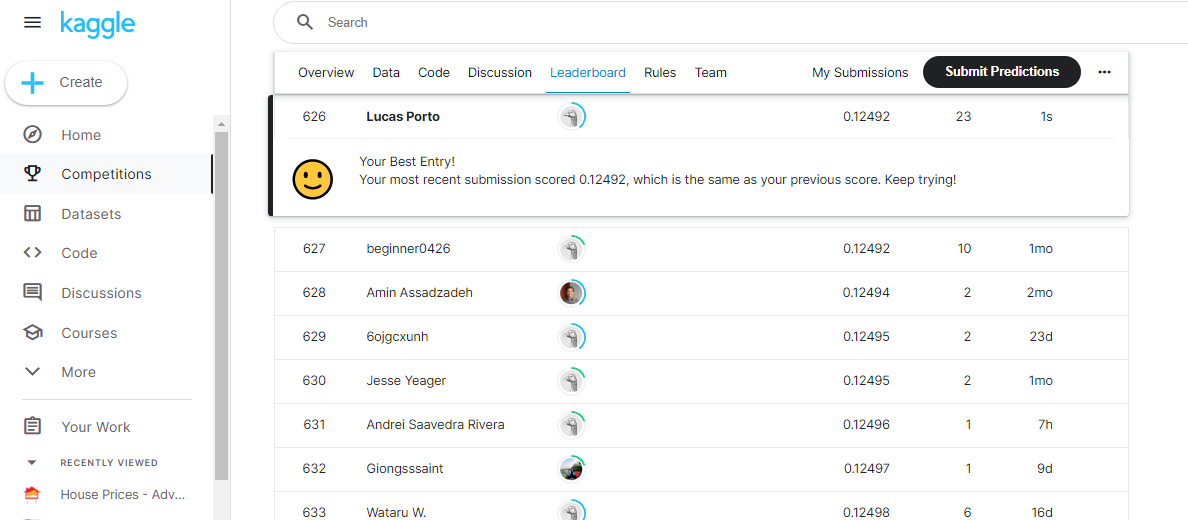

In [26]:
Image('foto.png')

## Comentários Finais 

<p style='text-align: justify;'>Este foi apenas um exemplo de como obter um bom score no Kaggle com poucas linhas de código. Existem diversas formar de melhorar o score e grande parte delas passa por um processo de Feature Engineering mais cuidadoso. Uma sugestão é procurar variáveis que estejam fortemente correlacionadas e que possam estar causando uma piora no modelo ou variáveis que não possuam poder preditivo em relação a variável alvo SalePrice . Uma abordagem mais técnica seria utilizar o método Recursive Feature Elimination para encontrar as variáveis mais importantes para o modelo. Espero que este trabalho possa servir como ponto de partida para essa competição.